# LSTM-CNN

Author: ZHANG Yu

The code is used to do calsssification of quickdraw dataset with 5 classes using neural network with LSTM encoder and CNN decoder. 

The model here can achieve 94.74%, 88.54%, 83.97% and 74.86% accuracy for complete dataset, 90% incomplete dataset, 70% incomplete dataset and 50% incomplete dataset respectively


### The simplified process is:
1. Get data
2. Convert data to desired formation
3. Choose hyperparameters
4. Construct LSTM-CNN network
5. Train the network
6. Evaluate the network 

### To run the code:
1. Change path and parameters
2. Run the code

In [1]:
import sys
import os
os.environ["CUDA VISIBLE_DEVICES"]="0"
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.switch_backend('agg')
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Conv2D, Reshape
from keras.callbacks import LearningRateScheduler
import keras.backend as K
from sklearn.metrics import confusion_matrix
import utils_
from utils_ import get_dataset, find_max_strok_point, convert_to_zeropad, label_onehot, plot_history


Using TensorFlow backend.


## Get data
test_r1=0.9 means stoke numbers in test_X1 is 90% of original data

In [2]:
data_path = '/raid5/liuchang/quick_draw_output' # change path here
data_name = '1102_05b633244'

train_X,train_Y,test_X,test_Y,test_X1,test_X2,test_X3=get_dataset(data_path,data_name,test_r1=0.9,test_r2=0.7,test_r3=0.5)




## Preprocess data
Zero padding both train data and test data to same length

Convert label to onehot form to fit 'mean_squared_error' loss function's requirement

#### Normalize data
Make sure that mean over entire training data is zero. For testing data, subtract the mean vector of the training data rather than the mean of testing data. Since the mean of testing data at runtime was unknown

Normalization makes training less sensitive to the scale of features

Normalizing will ensure that a convergence problem does not have a massive variance, making optimization feasible, which accelarates the training process to some degree

In [3]:

max_stroke,max_point=find_max_strok_point(train_X,test_X)
train_data = convert_to_zeropad(train_X,max_stroke,max_point)
train_label = label_onehot(train_Y)
test_label = label_onehot(test_Y)
test_data = convert_to_zeropad(test_X,max_stroke,max_point)
test_data1 = convert_to_zeropad(test_X1,max_stroke,max_point)
test_data2 = convert_to_zeropad(test_X2,max_stroke,max_point)
test_data3 = convert_to_zeropad(test_X3,max_stroke,max_point)


max stroke number in train data = 30 
 max point number in train data = 200
training data number = 400000
max stroke number in test data = 30 
 max point number in test data = 200
test data number = 126649
done
done
done
done
done


In [4]:
mean= train_data.mean()
std= train_data.std()

train_data = (train_data - mean)/std
test_data = (test_data - mean)/std
test_data1 = (test_data1 - mean)/std
test_data2 = (test_data2 - mean)/std
test_data3 = (test_data3 - mean)/std


## Setting parameters

In [5]:
bs = 128 # batch size, each batch has n images
seq_len = max_stroke 
input_size = 2*max_point 
hidden_size = 400
output_size = 5 # n calsses
feature_size = 256
filter_num1 = 50
filter_num2 = 100
dense1 = 80
EPOCH = 40 # train the training data n times



## Build lstm-rnn model
My goal is to construct a neural network using lstm as encoder and cnn as decoder.

Firstly I construct a lstm network, whose output size is selected as 256, which actually is the feature encoded by the lstm. Then I send the featured I got above to a 2 layer CNN network, which uses the feature learned rather than the raw data information to do the classification 

The following architecture and parameters are chosen after several trails

In [6]:
model = Sequential()
model.add(LSTM(hidden_size,return_sequences=False,input_shape=(seq_len,input_size))) #bs*seq_len*input_size-->bs*seq_len*hidden_size, select last score
model.add(Dense(feature_size, activation='linear')) #bs*hidden_size-->bs*feature_size
model.add(Reshape((16,16,1))) #bs*feature_size-->bs*16*16*1
model.add(Conv2D(filter_num1,3,strides=(2,2), activation ='relu')) #bs*16*16*1-->bs*7*7*50
model.add(Conv2D(filter_num2,3,strides=(2,2), activation ='relu')) #bs*7*7*50-->bs*3*3*100
model.add(Flatten()) #bs*3*3*100-->bs*900
model.add(Dense(dense1, activation='relu')) #bs*900-->bs*dense1
model.add(Dropout(0.2))
model.add(Dense(output_size, activation='linear')) #bs*dense1-->bs*output_size

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               102656    
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 50)          500       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 100)         45100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                72080     
__________

### Reducing learning rate by 0.9 every two epoch

In [7]:
def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)


## Compile model
* Loss function: evaluating how well the algorithm models the dataset. mean square error is one of the simplest loss function
* Optimizer: Adam is chosen as the oprimizer, it converges a lot faster

In [8]:
adam = optimizers.Adam(lr=0.001)

model.compile(loss='mean_squared_error',
          optimizer='adam',
          metrics=['accuracy'])

## Train and evaluate the model
plot loss and accuracy 

show test accuracy of complete and imcomplete images

#### Learning rate
Usually initial learning rate=1e-3,5e-4 for Adam optimizer, decreasing it is essential, here it is decreased by 0.1 every 2 epoches

#### Loss vs. epoches
Loss increases consistently: (a)learning rate is likely set too high; (b)indicative of other network issues such as incorrect data normalization
Loss is flat or decreases very slowly (over a few hundred iterations): (a)learning rate may be too low; (b)having difficulties with optimization
#### Accuracy vs. epoches
The validation accuracy is higher than the training accuracy in the first several epoches from which shown below. This can happen when the validation set is small and the model is underfitting, usually this phenomenon will go away as trainning more.

Train on 320000 samples, validate on 80000 samples
Epoch 1/40
320000/320000 [==============================] - 1319s 4ms/step - loss: 0.0404 - acc: 0.8772 - val_loss: 0.0267 - val_acc: 0.9104
Epoch 2/40
320000/320000 [==============================] - 1485s 5ms/step - loss: 0.0271 - acc: 0.9216 - val_loss: 0.0224 - val_acc: 0.9275
Epoch 3/40
lr changed to 0.0009000000427477062
320000/320000 [==============================] - 1502s 5ms/step - loss: 0.0242 - acc: 0.9314 - val_loss: 0.0200 - val_acc: 0.9337
Epoch 4/40
320000/320000 [==============================] - 1526s 5ms/step - loss: 0.0227 - acc: 0.9367 - val_loss: 0.0209 - val_acc: 0.9324
Epoch 5/40
lr changed to 0.0008100000384729356
320000/320000 [==============================] - 1594s 5ms/step - loss: 0.0213 - acc: 0.9418 - val_loss: 0.0183 - val_acc: 0.9392
Epoch 6/40
320000/320000 [==============================] - 1574s 5ms/step - loss: 0.0205 - acc: 0.9444 - val_loss: 0.0197 - val_acc: 0.9346
Epoch 7/40
lr changed to 0.0007

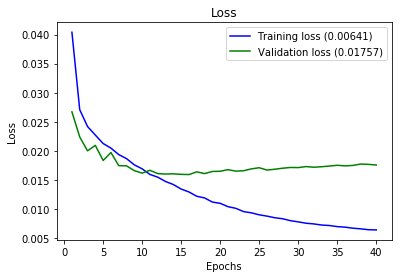

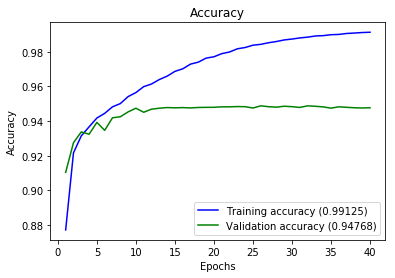

In [9]:
lr_decay = LearningRateScheduler(scheduler)
   

history = model.fit(train_data, train_label,
          batch_size = bs, epochs=EPOCH , 
          verbose=1,validation_split=0.2,callbacks=[lr_decay])

%matplotlib inline
plot_history(history)



In [10]:
test_loss, test_acc = model.evaluate(test_data, test_label,
                                         batch_size=bs)
print('complete stroke test score:', test_loss)
print('complete stroke test accuracy:', test_acc)

test_loss1, test_acc1 = model.evaluate(test_data1, test_label,
                                         batch_size=bs)
print('90% stroke test score:', test_loss1)
print('90% stroke test accuracy:', test_acc1)
test_loss2, test_acc2 = model.evaluate(test_data2, test_label,
                                         batch_size=bs)
print('70% stroke test score:', test_loss2)
print('70% stroke test accuracy:', test_acc2)
test_loss3, test_acc3 = model.evaluate(test_data3, test_label,
                                         batch_size=bs)
print('50% stroke test score:', test_loss3)
print('50% stroke test accuracy:', test_acc3)

126649/126649 [==============================] - 164s 1ms/step
complete stroke test score: 0.01772024283732604
complete stroke test accuracy: 0.947421614073814
126649/126649 [==============================] - 158s 1ms/step
90% stroke test score: 0.03408886407999531
90% stroke test accuracy: 0.8853761182377176
126649/126649 [==============================] - 158s 1ms/step
70% stroke test score: 0.049230024420870745
70% stroke test accuracy: 0.8397460698357594
126649/126649 [==============================] - 167s 1ms/step
50% stroke test score: 0.0788282289123791
50% stroke test accuracy: 0.7485728272683974


## Plot confusion matrix of test data 
confusion matrix helps expressing the classification results

From the results shown below, it can be seen that the label 0, which is 'calender' class, has relatively lower predict accuracy compared to other 4 classes. This is because that 'calender' class has less training data than other classes

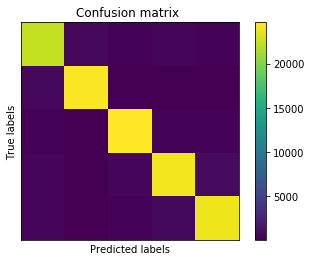

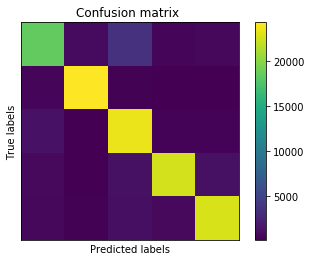

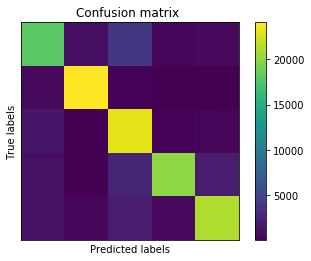

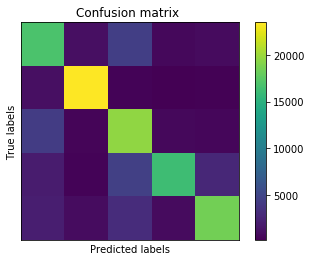

In [11]:
def test_confusion_matrix(test_data,test_Y):
    score_pred = model.predict(test_data)
    label_pred = np.argmax(score_pred,1)
    c_m = confusion_matrix(test_Y,label_pred)
    %matplotlib inline
    plt.imshow(c_m)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Confusion matrix ')
    plt.colorbar()
    plt.show()
    return 

test_confusion_matrix(test_data,test_Y)
test_confusion_matrix(test_data1,test_Y)
test_confusion_matrix(test_data2,test_Y)
test_confusion_matrix(test_data3,test_Y)




In [12]:
model.save('model_lstmcnnall.h5')